<a href="https://colab.research.google.com/github/edologgerbird/deep-learning-project/blob/develop_edmund/Project_Notebook_V2_EDO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image Caption Generator: Investigating the effects of the Attention Mechanism

Project by: Loh Hong Tak Edmund (S221545), Sim Wee Yang (S221547), Woo Jun Hao Bryan (S221526)


### Background

Image caption generation is the process of a computer being able to recognize the context of an image and annotating it with the relevant captions. Recent developments in artificial intelligence and natural language processing allowed image caption generation to gain traction amongst researchers. The applications of image captioning are extensive, and there are various related methods that allow us to achieve this task. We intend to narrow our research down to LSTMs, transformers and the attention mechanism.

This project aims to compare the performance of an LSTM-based model with that of a transformer-based model on the task of image caption generation. The project will employ performance metrics BLEU (Bilingual Evaluation Understudy) Score and Rouge (Recall Oriented Understudy for Gisting Evaluation) to identify the best performing model (Dayal, 2022).

### Flickr8k

This project will explore Image Caption Generation using the Flickr8k dataset, which is a benchmark collection for sentence-based image description and search. This set contains 8,000 images that are each paired with five different captions which describes the entities and events within each respective picture.

In [1]:
LOAD_FROM_PICKLE = True

### Setting up the Environment

Installing Relevent Modules

In [2]:
! pip install great_expectations ipywidgets rich seaborn torch datasets transformers tokenizers sentencepiece sacremoses --quiet

Importing relevant modules

In [3]:
%matplotlib inline
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rich
import random
from functools import partial
import pickle
import great_expectations as ge

import glob
import os
from tqdm.notebook import tqdm
from collections import Counter
from typing import List, Tuple, Optional, Dict, Any
from pathlib import Path
from IPython.display import clear_output
from skimage.io import imread
from skimage.transform import resize


import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.nn import Linear, GRU, Conv2d, Dropout, MaxPool2d, BatchNorm1d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary            
from torch.utils.data import Dataset

from PIL import Image 

import transformers
import tokenizers
import datasets
import zipfile
from huggingface_hub import hf_hub_download

# import data_utils
import gc
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [4]:
gc.collect()

112

In [5]:
!pip install scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Setting up Device

In [6]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rich.print(f"Device: [red]{DEVICE}")

Device: cpu

Constants

In [7]:
RANDOM_STATE = 42
TRAIN_SIZE = 0.70
VAL_SIZE = 0.15
TEST_SIZE = 0.15
IMAGE_SIZE = 256
BATCH_SIZE = 1
NUM_WORKERS = 1
NUM_CAPTIONS_PER_IMAGE = 5

Setting up Google Drive for development on Colab

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
drive_path = 'drive/My Drive/'

### Loading the data

We first start by loading the data, where we consolidate the image file names present in the data set. We also load the captions file, which contains the 5 captions tagged to their respective images.

In [10]:
image_paths = glob.glob(f'{drive_path}data/flickr_8k_dataset/Images/*.jpg')
print("Total Images:\t", len(image_paths))

captions = pd.read_csv(f'{drive_path}data/flickr_8k_dataset/captions.txt')
images = [f'{drive_path}data/flickr_8k_dataset/Images/{i}' for i in captions.image.values]

print(images[:3])
captions.head()

Total Images:	 8091
['drive/My Drive/data/flickr_8k_dataset/Images/1000268201_693b08cb0e.jpg', 'drive/My Drive/data/flickr_8k_dataset/Images/1000268201_693b08cb0e.jpg', 'drive/My Drive/data/flickr_8k_dataset/Images/1000268201_693b08cb0e.jpg']


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


### Data Sanity Check

Next, we perform preliminary data sanity checks to ensure the cleanliness and validity of the data. We will make use of the great_expectations (GE) package to assist in these checks.

In summary, we will perform the following checks:

1. No null values
2. Caption data are of appropriate types
3. No images listed in the captions file that are missing in the images folder, vice versa
4. Each image contains exactly 5 accompanying captions

In [11]:
def check_expectations(df, column, expectation):
  ge_df = ge.from_pandas(df)
  ge_result = ge_df.expect_column_values_to_be_in_set(column, expectation)

  return {
    "Outcome: ": ge_result["success"],
    "Results: ": ge_result["result"]
    }

In [12]:
check_expectations(captions, "image", [i.split("/")[-1] for i in image_paths]) # check if all image names in the captions df are present in the image_paths

{'Outcome: ': True,
 'Results: ': {'element_count': 40455,
  'missing_count': 0,
  'missing_percent': 0.0,
  'unexpected_count': 0,
  'unexpected_percent': 0.0,
  'unexpected_percent_total': 0.0,
  'unexpected_percent_nonmissing': 0.0,
  'partial_unexpected_list': []}}

In [13]:
caption_counts = captions.groupby("image").count()

check_expectations(caption_counts, "caption", [5]) # check that all images have 5 accompanying captions

{'Outcome: ': True,
 'Results: ': {'element_count': 8091,
  'missing_count': 0,
  'missing_percent': 0.0,
  'unexpected_count': 0,
  'unexpected_percent': 0.0,
  'unexpected_percent_total': 0.0,
  'unexpected_percent_nonmissing': 0.0,
  'partial_unexpected_list': []}}

In [14]:
assert(set(captions["image"]) == set([i.split("/")[-1] for i in image_paths]))

Data passes sanity checks. There are no null and missing values, and the columns contain the expected image files names and the number of accomanying captions per image.

### Visualising the Data

First, we would like to visualise a few sample images.

In [15]:
def get_sample_image(image_paths, n):
  sample_images_path = random.sample(image_paths,n)
  sample_images_name = [i.split('/')[-1] for i in sample_images_path] 
  return sample_images_path, sample_images_name

def show_image(image_path):
  image = imread(image_path)
  plt.imshow(image)
  plt.axis('off')

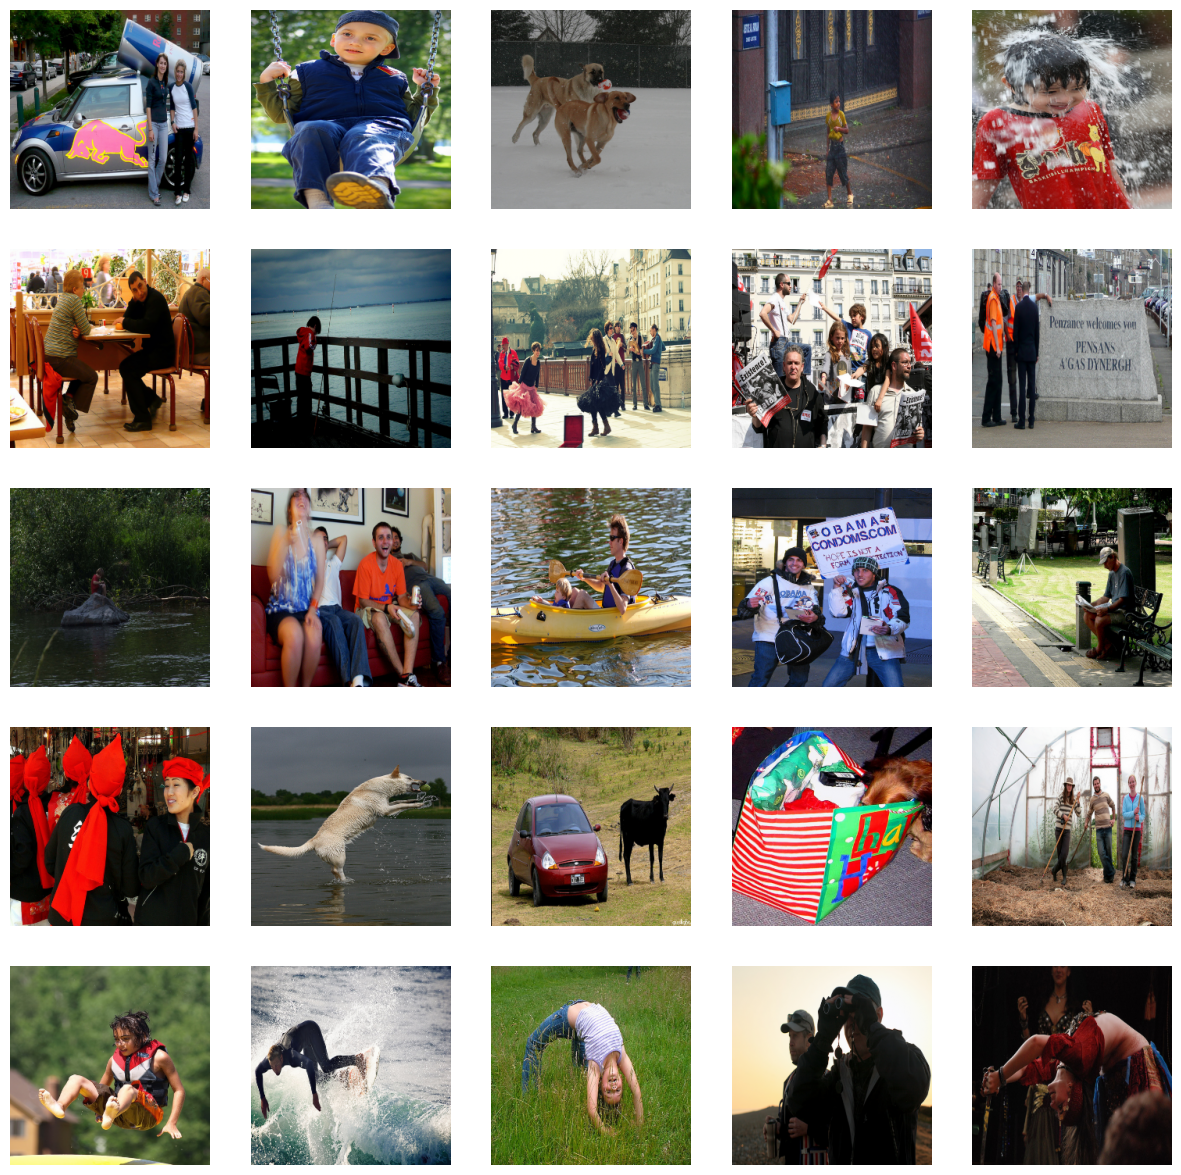

In [16]:
n_samples = 5*5
sample_images_path, sample_images_name = get_sample_image(image_paths,n_samples)

fig = plt.figure(figsize=(15, 15))

columns = 5
rows = 5

for i in range(len(sample_images_path)):
  image = imread(sample_images_path[i])
  image = resize(image, (IMAGE_SIZE,IMAGE_SIZE))
  fig.add_subplot(rows, columns, i+1)
  plt.imshow(image)
  plt.axis('off')

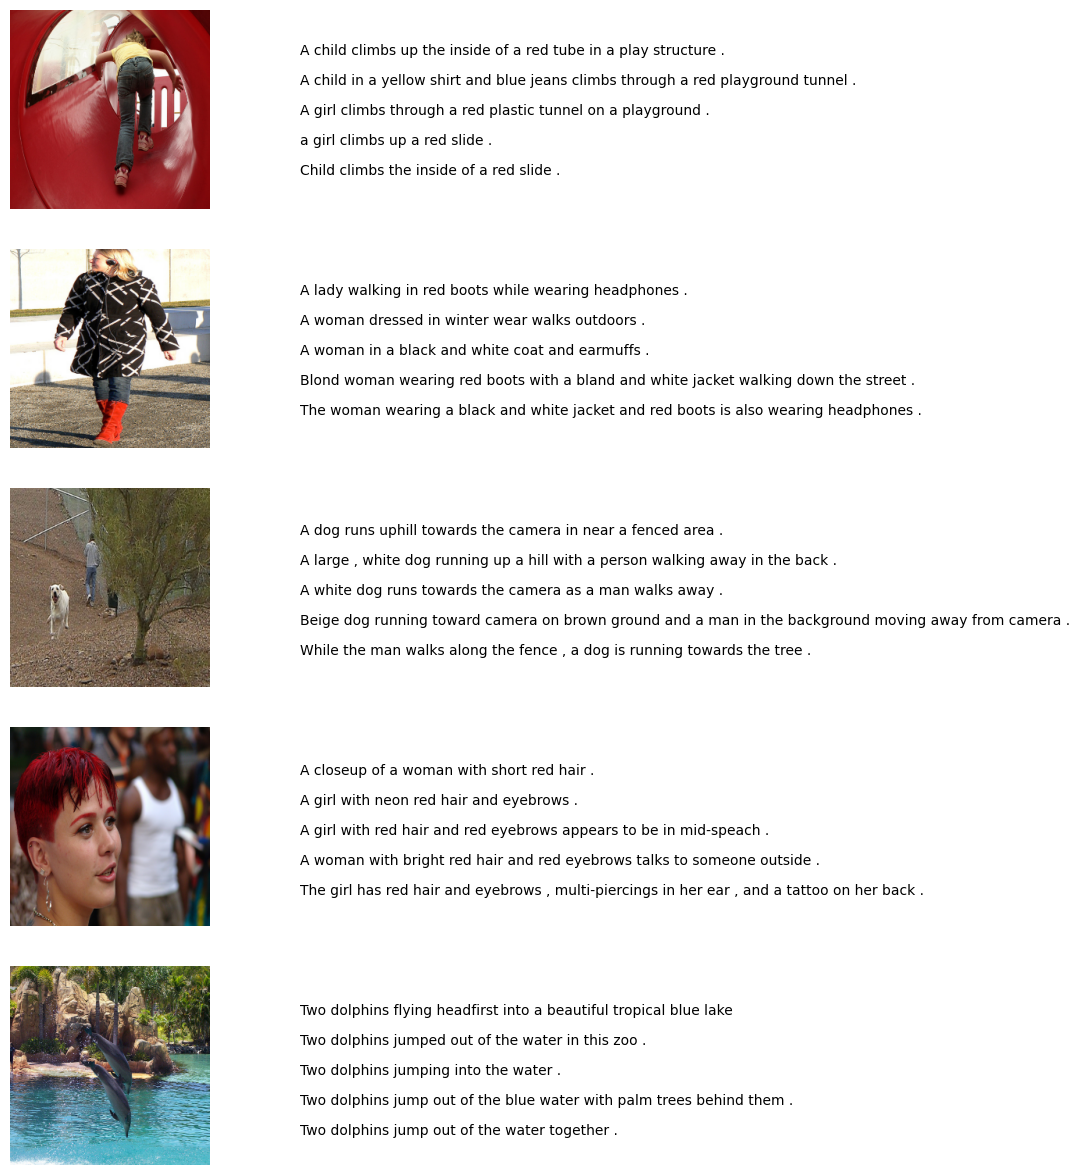

In [17]:
n_samples = 5
sample_images_path, sample_images_name = get_sample_image(image_paths,n_samples)

sample_images_captions = {i:captions[captions["image"] == i]["caption"].values for i in sample_images_name}

fig = plt.figure(figsize=(8, 15))

columns = 1
rows = 5

for i in range(len(sample_images_path)):
  image = imread(sample_images_path[i])
  image = resize(image, (IMAGE_SIZE,IMAGE_SIZE))
  fig.add_subplot(rows, columns, i+1)
  plt.imshow(image)
  plt.axis('off')
  for enum, caption in enumerate(sample_images_captions[sample_images_name[i]]):
    plt.figtext(0.75,0.85+i*-0.16-0.02*enum, caption)

### Caption and Image Data Preparation

Due to the sequence generation nature of the model, we need to input special words indicating START, END, UKNOWN, PAD, to indicate when the sequence starts, ends, is an unseen word, or is a padding token respectively.

In [18]:
start_token = "<|start|>"
end_token = "<|end|>"
unknown_token = "<|unk|>"
pad_token = "<|pad|>"

In [19]:
max_caption_length = max(captions["caption"].apply(lambda x: len(x.split())))

def add_special_tokens(caption):
  n_pads = max_caption_length - len(caption.split())
  updated_caption = start_token + " " + caption + " " + end_token + n_pads * (" " + pad_token)
  return updated_caption

In [20]:
captions['caption_pad'] = captions['caption'].apply(lambda x: add_special_tokens(x))
captions['caption_pad']

0        <|start|> A child in a pink dress is climbing ...
1        <|start|> A girl going into a wooden building ...
2        <|start|> A little girl climbing into a wooden...
3        <|start|> A little girl climbing the stairs to...
4        <|start|> A little girl in a pink dress going ...
                               ...                        
40450    <|start|> A man in a pink shirt climbs a rock ...
40451    <|start|> A man is rock climbing high in the a...
40452    <|start|> A person in a red shirt climbing up ...
40453    <|start|> A rock climber in a red shirt . <|en...
40454    <|start|> A rock climber practices on a rock c...
Name: caption_pad, Length: 40455, dtype: object

In [21]:
captions['caption_pad'][0]

'<|start|> A child in a pink dress is climbing up a set of stairs in an entry way . <|end|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|>'

In [22]:
set(captions['caption_pad'].apply(lambda x: len(x.split())))

{40}

#### Loading GloVe Pretrained Embeddings

In [23]:
# control verbosity
transformers.logging.set_verbosity_error()
datasets.logging.set_verbosity_error()

# define support functions
def load_glove_vectors(filename = "glove.6B.300d.txt") -> Tuple[List[str], torch.Tensor]:
    """Load the GloVe vectors. See: `https://github.com/stanfordnlp/GloVe`"""
    path = Path(hf_hub_download(repo_id="stanfordnlp/glove", filename="glove.6B.zip"))
    target_file = path.parent / filename
    if not target_file.exists():
        with zipfile.ZipFile(path, 'r') as zip_ref:
            zip_ref.extractall(path.parent)

        if not target_file.exists():
            print(f"Available files:")
            for p in path.parent.iterdir():
                print(p)
            raise ValueError(f"Target file `{target_file.name}` can't be found. Check if `{filename}` was properly downloaded.")

    # parse the vocabulary and the vectors
    vocabulary = []
    vectors = []
    with open(target_file, "r") as f:
        for l in tqdm(f.readlines(), desc=f"Parsing {target_file.name}..." ):
            word, *vector = l.split()
            vocabulary.append(word)
            vectors.append(torch.tensor([float(v) for v in vector]))
    vectors = torch.stack(vectors)
    return vocabulary, vectors

In [24]:
if not LOAD_FROM_PICKLE:
  # prepare data for the later cells
  glove_vocabulary, glove_vectors = load_glove_vectors()
  rich.print(f"glove_vocabulary: type={type(glove_vocabulary)}, length={len(glove_vocabulary)}")
  rich.print(f"glove_vectors: type={type(glove_vectors)}, shape={glove_vectors.shape}, dtype={glove_vectors.dtype}")

  # add special tokens
  special_tokens = [start_token, end_token, unknown_token, pad_token]
  glove_vocabulary = special_tokens + glove_vocabulary
  glove_vectors = torch.cat([torch.randn_like(glove_vectors[:len(special_tokens)]), glove_vectors])

  # tokenizer for GloVe
  glove_tokenizer = tokenizers.Tokenizer(tokenizers.models.WordLevel(vocab={v:i for i,v in enumerate(glove_vocabulary)}, unk_token=unknown_token))
  glove_tokenizer.normalizer = tokenizers.normalizers.BertNormalizer(strip_accents=False)
  glove_tokenizer.pre_tokenizer = tokenizers.pre_tokenizers.WhitespaceSplit()

  # glove_tokenizer
  with open(f'{drive_path}data/flickr_8k_dataset/tokenizer.gz', 'wb') as f: # "wb" because we want to write in binary mode
      pickle.dump(glove_tokenizer, f)
      print("SUCCESS: GLOVE tokeniser pickled successfully")

  # glove_vocab
  with open(f'{drive_path}data/flickr_8k_dataset/vocab.gz', 'wb') as f: # "wb" because we want to write in binary mode
      pickle.dump(glove_vocabulary, f)
      print("SUCCESS: GLOVE vocabulary pickled successfully")

  # glove vectors
  with open(f'{drive_path}data/flickr_8k_dataset/vectors.gz', 'wb') as f: # "wb" because we want to write in binary mode
      pickle.dump(glove_vectors, f)
      print("SUCCESS: GLOVE vectors pickled successfully")

else:
  with open(f'{drive_path}data/flickr_8k_dataset/tokenizer.gz', 'rb') as f: # "rb" because we want to read in binary mode
    glove_tokenizer = pickle.load(f)
    print("SUCCESS: GLOVE tokeniser loaded successfully")

  with open(f'{drive_path}data/flickr_8k_dataset/vocab.gz', 'rb') as f: # "rb" because we want to read in binary mode
    glove_vocabulary = pickle.load(f)
    print("SUCCESS: GLOVE vocabulary loaded successfully")

  with open(f'{drive_path}data/flickr_8k_dataset/vectors.gz', 'rb') as f: # "rb" because we want to read in binary mode
    glove_vectors = pickle.load(f)
    print("SUCCESS: GLOVE vectors loaded successfully")


SUCCESS: GLOVE tokeniser loaded successfully
SUCCESS: GLOVE vocabulary loaded successfully
SUCCESS: GLOVE vectors loaded successfully


In [25]:
# Encode the captions

captions['caption_ids'] = captions['caption_pad'].apply(lambda x: glove_tokenizer.encode(x).ids)

In [26]:
captions['caption_ids']

0        [0, 11, 968, 10, 11, 5495, 4639, 18, 6856, 64,...
1        [0, 11, 1753, 226, 79, 11, 4840, 451, 6, 1, 3,...
2        [0, 11, 337, 1753, 6856, 79, 11, 4840, 19623, ...
3        [0, 11, 337, 1753, 6856, 4, 12322, 8, 75, 1962...
4        [0, 11, 337, 1753, 10, 11, 5495, 4639, 226, 79...
                               ...                        
40450    [0, 11, 304, 10, 11, 5495, 5102, 15655, 11, 11...
40451    [0, 11, 304, 18, 1141, 6856, 156, 10, 4, 329, ...
40452    [0, 11, 903, 10, 11, 643, 5102, 6856, 64, 11, ...
40453    [0, 11, 1141, 20930, 10, 11, 643, 5102, 6, 1, ...
40454    [0, 11, 1141, 20930, 3253, 17, 11, 1141, 6856,...
Name: caption_ids, Length: 40455, dtype: object

Next, we split the images into train, validation and test data. The same image should not be present in the training, validation and test data sets. To ensure this, we will split the training and test sets by unique image names.

In [27]:
unique_image_names = list(set(captions["image"].values))

random.seed(RANDOM_STATE)

train_image_names = random.sample(unique_image_names, int(len(unique_image_names)*TRAIN_SIZE))
val_test_image_names = [image for image in unique_image_names if image not in train_image_names]
val_image_names = random.sample(val_test_image_names, int(len(unique_image_names)*VAL_SIZE))
test_image_names = [image for image in val_test_image_names if image not in val_image_names]


train_captions = captions[captions['image'].isin(train_image_names)].reset_index(drop=True)
val_captions = captions[captions['image'].isin(val_image_names)].reset_index(drop=True)
test_captions = captions[captions['image'].isin(test_image_names)].reset_index(drop=True)

print(f"Train Images: {len(train_image_names)}")
print(f"Validation Images: {len(val_image_names)}")
print(f"Test Images: {len(test_image_names)}")

print(f"Train Captions: {train_captions.shape[0]}")
print(f"Validation Captions: {val_captions.shape[0]}")
print(f"Test Captions: {test_captions.shape[0]}")

Train Images: 5663
Validation Images: 1213
Test Images: 1215
Train Captions: 28315
Validation Captions: 6065
Test Captions: 6075


In [28]:
train_captions["caption"].apply(lambda x: len(x.split()))

0        18
1         8
2         9
3        10
4        13
         ..
28310    10
28311    10
28312    16
28313     8
28314    10
Name: caption, Length: 28315, dtype: int64

Creating a custom dataloader class.

In [29]:
class ImageCaptionDataset(Dataset):

  def __init__(self, drive_path, image_names, captions, split, num_captions_per_image, transform=None):
    self.split = split
    self.image_names = image_names
    self.num_captions_per_image = num_captions_per_image
    self.captions_ids = captions["caption_ids"]
    self.caption_lengths = captions["caption"].apply(lambda x: len(x.split()))
    self.transform = transform
    self.dataset_size = self.captions_ids.size

  def __getitem__(self, caption_number):
    image_number = caption_number // self.num_captions_per_image

    load_image = imread(f"{drive_path}data/flickr_8k_dataset/Images/"+self.image_names[image_number])
    load_image = resize(load_image, (IMAGE_SIZE,IMAGE_SIZE))
    image = torch.FloatTensor(load_image/255)
    image = image.permute(2,0,1) 

    if self.transform:
      image = self.transform(image)

    caption = torch.LongTensor(self.captions_ids[caption_number])
    caption_length = torch.LongTensor([self.caption_lengths[caption_number]])

    if self.split == 'TRAIN':
      return image, caption, caption_length

    else:
      caption_ind = (caption_number // self.num_captions_per_image) * self.num_captions_per_image
      all_captions = torch.LongTensor(
          self.captions_ids[caption_ind : caption_ind + self.num_captions_per_image]
      )
      return image, caption, caption_length, all_captions

  def __len__(self):
    return self.dataset_size    

In [30]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Mean and Std of ImageNet Channels



train_loader = torch.utils.data.DataLoader(
    ImageCaptionDataset(drive_path, train_image_names, train_captions, 'TRAIN', NUM_CAPTIONS_PER_IMAGE, transform=transforms.Compose([normalize])),
    batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True
)

val_loader = torch.utils.data.DataLoader(
    ImageCaptionDataset(drive_path, val_image_names, val_captions, 'VAL', NUM_CAPTIONS_PER_IMAGE, transform=transforms.Compose([normalize])),
    batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True
)

## Encoder

In this section, we will be defining the encoder class. This encoder will utilise the concept of transfer learning, where we will load the pretrained model VGG16. However, since we are not classifying the images at this stage, we will be modifying the last layer of the VGG16 network so that it will output the entire convolution feature set.

In [31]:
# Setting up the vgg16 model for transfer learning
vgg16 = models.vgg16_bn(weights="IMAGENET1K_V1").to(DEVICE)
print(f"Number of predicted features: {vgg16.classifier[6].out_features}")

# We freeze training for all layers in the vgg16 model
for param in vgg16.features.parameters():
    param.require_grad = False

# View layers in the VGG16 Model
summary(vgg16, (3, 224, 224))  

Number of predicted features: 1000
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]         147,584
      BatchNorm2d-12        [-1, 128, 112, 112]             256
             ReLU-13        [-1, 128, 112, 112]               0
    

In [32]:
from torch.nn.modules import module
# Encoder Class

class Encoder(nn.Module):
  def __init__(self, encoded_image_size = 14):
    super(Encoder, self).__init__()
    self.encoded_image_size = encoded_image_size

    vgg16 = models.vgg16_bn(weights="IMAGENET1K_V1").to(DEVICE)
    for param in vgg16.features.parameters():
      param.require_grad = False

    modules = list(vgg16.children())[:-2]
    self.vgg16 = nn.Sequential(*modules)
    self.adaptive_pool = nn.AdaptiveAvgPool2d((self.encoded_image_size, self.encoded_image_size))

  def forward(self, image_batch): 
    output = self.vgg16(image_batch)    # [batch_size, 512, image_size/32, image_size/32]
    output = self.adaptive_pool(output) # [batch_size, 512, encoded_image_size, encoded_image_size]
    output = output.permute(0,2,3,1)    # [batch_size, encoded_image_size, encoded_image_size, 512]
    return output


In [52]:
# Testing encoder

encoder = Encoder()
decoder = Decoder(512, 512, 512, len(glove_vocabulary))

decoder.to(DEVICE)
encoder.to(DEVICE)
encoder.train()
decoder.train()

for i, (images, captions, caption_length) in enumerate(train_loader):
  import gc
  gc.collect()
  images.to(DEVICE)
  captions.to(DEVICE)
  caption_length.to(DEVICE)

  images = encoder(images)
  scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(images, captions, caption_length)
  if i == 1:
    break

In [ ]:
rich.print(f"Image Size per batch: [green]{images.size()}")
rich.print(f"Captions Size per batch: [green]{captions.size()}")
rich.print(f"Captions Length Size per batch: [green]{caption_length.size()}")

Image Size per batch: torch.Size([16, 14, 14, 512])

Captions Size per batch: torch.Size([16, 40])

Captions Length Size per batch: torch.Size([16, 1])

In [59]:
sort_ind

tensor([0])

## Attention Module

In this section, we will define the attention mechanism. We have chosen the Scaled Dot Product Attention Mechanism as defined in "Attention is All you need". It is highly efficient and optimised, which will speed up our training process.

In [50]:
class ScaledDotProductAttention(nn.Module):
  def __init__(self, encoder_dim, decoder_dim, attention_dim):
    super(ScaledDotProductAttention, self).__init__()
    self.encoder_att = nn.Linear(encoder_dim, attention_dim)
    self.decoder_att = nn.Linear(decoder_dim, attention_dim)
    self.projected_att = nn.Linear(attention_dim, 1)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, encoder_output, decoder_hidden):
    encoder_att_output = self.encoder_att(encoder_output)
    decoder_att_output = self.decoder_att(decoder_hidden)
    scaled_att = ((encoder_att_output * decoder_att_output)/(np.sqrt(encoder_output.size(1)))) * encoder_att_output
    projected_att_output = self.projected_att(scaled_att).squeeze(2)
    alpha = self.softmax(projected_att_output)
    attention_weighted_encoding = (encoder_output * alpha.unsqueeze(2)).sum(dim=1)
    return attention_weighted_encoding, alpha
